In [4]:
!nvidia-smi

Sun Aug  6 05:11:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !sudo fuser -v /dev/nvidia*
# !sudo kill -9 5696
# %pip install tqdm


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from torch import nn, optim

import torchvision
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

torch.manual_seed(369)
np.random.seed(369)


### WGAN-gp

In [6]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0)
        )

        self._initialize_weights()

    def _block(
        self, in_channels, out_channels, kernel_size, stride, padding
    ):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(.2)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

    def forward(self, x):
        return self.critic(x)


class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            # input: N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

        self._initialize_weights()

    def _block(
        self, in_channels, out_channels, kernel_size, stride, padding
    ):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

    def forward(self, x):
        return self.gen(x)


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 1e-4
BATCH_SIZE = 64

IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 128
FEATURES_MODEL = 128

CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_MODEL).to(device)
# critic = Critic(CHANNELS_IMG, FEATURES_MODEL).to(device)
gen = torch.load('./gen_model_50.pth').to(device)
critic = torch.load('./critic_model_50.pth').to(device)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

transforms = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(
        [.5 for _ in range(CHANNELS_IMG)],
        [.5 for _ in range(CHANNELS_IMG)]
    )
])

dataset = datasets.ImageFolder(root='../data', transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

fixed_noise = torch.tensor(np.load('../fixed_noise.npy')).to(device)
counter = 51


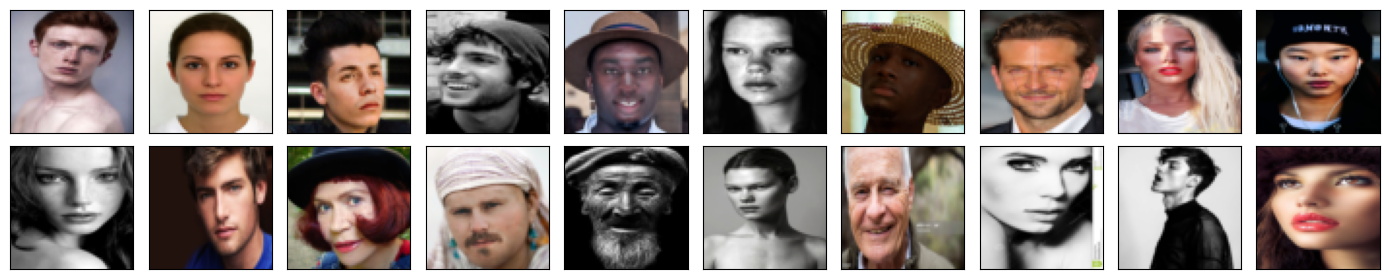

In [8]:
images, _ = next(iter(loader))
images = images.numpy()

def setup(img):
    img = np.transpose(img, (1, 2, 0))
    img = 255 * (img - img.min())/(img.max()-img.min())
    return img.astype('uint8')

fig, axes = plt.subplots(2, 10, figsize=(14, 3))
axes = axes.flatten()

for ax, img in zip(axes, images[:20]):
    ax.imshow(setup(img))
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


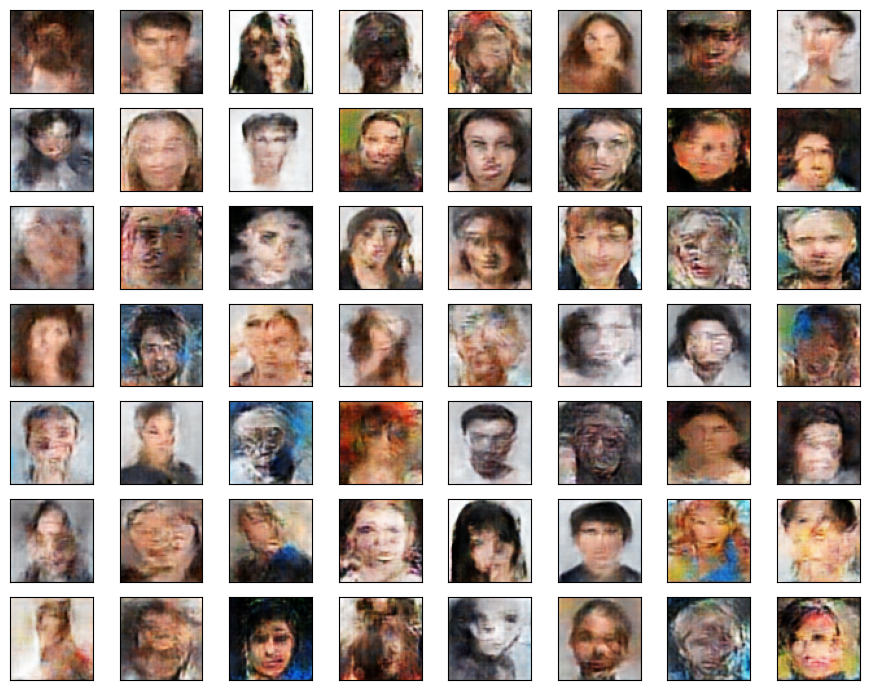

In [16]:
noise = torch.randn(56, 128, 1, 1).to(device)
res = gen(noise).detach().cpu().numpy()

fig, axes = plt.subplots(7, 8, figsize=(9, 7))
axes = axes.flatten()

for i, img in enumerate(res):
    axes[i].imshow(setup(img))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()


In [14]:
def gradient_penalty(critic, real, fake, device='cpu'):
    BATCH_SIZE, C, H, W = real.shape
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)

    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # calculate critic scores
    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]

    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2).to(device)
    return gradient_penalty

def save_results(epoch, c_loss, g_loss):
    gen.eval()

    with torch.no_grad():
        fake_data = gen(fixed_noise).detach().cpu().numpy()

    fig, axes = plt.subplots(8, 8, figsize=(16, 16))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(setup(fake_data[i]))
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'./logs/evolution/{epoch}_g_[{g_loss:.3f}]_c_[{c_loss:.3f}].png', bbox_inches='tight')
    plt.close()

    if epoch % 10 == 0:
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))

        ax[0].plot(losses)
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Model Loss')
        ax[0].legend(['Discriminator', 'Generator'])
        ax[0].grid()

        ax[1].plot(losses[:, 0], losses[:, 1], 'ko')
        ax[1].set_xlabel('Discriminator Loss')
        ax[1].set_ylabel('Generator Loss')

        ax[2].plot(disDecs)
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Probability ("real")')
        ax[2].set_title('Discriminator Output')
        ax[2].legend(['Real', 'Fake'])
        ax[2].grid()

        plt.tight_layout()
        plt.savefig(f'./logs/metrics/till_{epoch}.png')

        plt.close()
    
    gen.train()


### Training Time
<pre>
5 Aug 2023 : 00-50  epoch -> 6.640538617836104  hrs
6 Aug 2023 : 50-52  epoch -> 0.2721551444133123 hrs
6 Aug 2023 : 52-103 epoch -> 6.875306556622188  hrs
</pre>

In [24]:
start_time = time.time()
gen.train()
critic.train()

N_EPOCHS = 50
N_EPOCHS += 1

if ('losses' not in locals()) and ('disDecs' not in locals()):
    losses = np.zeros((1, 2))
    disDecs = np.zeros((1, 2))

loop = tqdm(range(N_EPOCHS))

for epoch_i in loop:
    for real, _ in loader:
        real_images = real.to(device)

        # Train the critic
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
            fake_images = gen(noise).to(device)

            ## forward passs for REAL pictures
            pred_real = critic(real_images).reshape(-1)

            ## forward passs for FAKE pictures
            pred_fake = critic(fake_images).reshape(-1)

            gp = gradient_penalty(critic, real_images, fake_images, device)

            ## calculate the loss
            loss_critic = -(torch.mean(pred_real) - torch.mean(pred_fake)) + LAMBDA_GP*gp

            ## backprop
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train the generator

        ## forward pass for FAKE pictures
        pred_fake = critic(fake_images).reshape(-1)

        ## compute loss
        g_loss = -torch.mean(pred_fake)

        ## backprop
        gen.zero_grad()
        g_loss.backward()
        opt_gen.step()

        loop.set_postfix(critic_loss=loss_critic.item(), g_loss=g_loss.item())

    with torch.no_grad():
        losses_ = np.empty(2)
        disDecs_ = np.empty(2)

        losses_[1] = g_loss.item()
        disDecs_[1] = torch.mean((pred_fake > 0.5).float()).detach()

        losses_[0] = loss_critic.item()
        disDecs_[0] = torch.mean((pred_real > 0.5).float()).detach()

        losses = np.vstack([losses, losses_])
        disDecs = np.vstack([disDecs, disDecs_])

    save_results(counter, loss_critic.item(), g_loss.item())
    counter += 1


  0%|          | 0/51 [01:10<?, ?it/s, critic_loss=-60.7, g_loss=238]/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 51/51 [6:52:31<00:00, 485.32s/it, critic_loss=-75.5, g_loss=215]  


In [25]:
elaped_time = time.time() - start_time
elaped_time /60 /60


6.875306556622188

In [29]:
torch.save(gen, f'gen_model_{counter}.pth')
torch.save(critic, f'critic_model_{counter}.pth')


In [27]:
counter


104